## Detección de novedad

En Machine Learning y Estadística existen varios problemas que pueden ser tratados de manera similar. Estos son:

* Detección de outliers
* Detección de novedad
* Detección de anormalidad
* Clasificación de una clase

Los datos con los que vamos a trabajar se pueden descargar de: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
data = pd.read_csv('local/data/creditcard.csv',sep=',')
data[:5]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


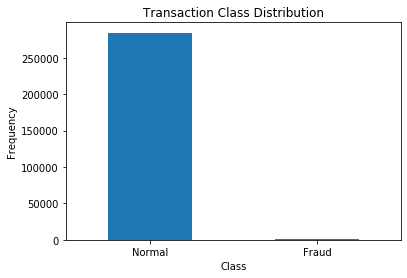

In [2]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
LABELS = ["Normal", "Fraud"]
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [3]:
Fraud = data[data['Class']==1]
Normal = data[data['Class']==0]
print('Porcentaje de fraude en la base de datos = ', Fraud.shape[0]/data.shape[0]*100, '%')

Porcentaje de fraude en la base de datos =  0.1727485630620034 %


In [2]:
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [4]:
X1 = Normal.values[:100000,:]
X2 = Fraud.values

Porcentaje = 0.71

N1 = X1.shape[0]
N2 = X2.shape[0]

Ytrain = np.r_[np.ones(round(N1*Porcentaje)),-1*np.ones(round(N2*Porcentaje))]

Xtrain = np.r_[X1[:round(N1*Porcentaje),:],X2[:round(N2*Porcentaje),:]]
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(np.r_[X1[round(N1*Porcentaje):,:],X2[round(N2*Porcentaje):,:]])
Ytest = np.r_[np.ones(round(N1*(1-Porcentaje))),-1*np.ones(round(N2*(1-Porcentaje)))]
clf = svm.SVC(C=1, kernel="rbf", gamma=0.01)
clf.fit(Xtrain, Ytrain)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Normalized confusion matrix
[[0.97202797 0.02797203]
 [0.         1.        ]]


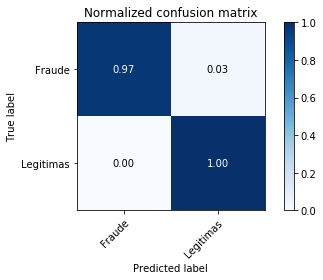

In [5]:
from local.lib.plotCM import plot_confusion_matrix
class_names = np.array(['Fraude','Legitimas'])
Ytest = (Ytest + 1)/2
Yest = clf.predict(Xtest)
Yest = (Yest + 1)/2
disp = plot_confusion_matrix(Ytest.astype(int),Yest.astype(int),class_names)

In [6]:
clf.n_support_

array([ 85, 325], dtype=int32)

Una forma alternativa de resolver el problema es estimar una función de densidad de probabilidad sobre el conjunto **Mayoritario** y definir un umbral a partil del cual se puede considerar que una nueva muestra pertenece al conjunto Mayoritario o no. Una forma alternativa es emplear un clasificador de una clase.

#### One-class classifier

El clasificador de una clase es una modificación del método de clasificación SVM para el problemas de una sola clase. 

<img src="./imgs/One-class.png" alt="One-class" width="300"/>
Imagen tomada de: https://en.wikipedia.org/wiki/One-class_classification

Considere un conjunto de datos sin etiqueta $X = \{{\bf{x}}_1,...,{\bf{x}}_m\} \subset \mathcal{X}$. Sea $\phi$ una función de mape de $\mathcal{X} \rightarrow \mathcal{H}$, tal que el producto punto en $\mathcal{H}$ puede ser calculado usando algún kernel simple:

$$k({\bf{x}},{\bf{x}}') = \langle \phi({\bf{x}}), \phi({\bf{x}}')\rangle$$

Se desea obtener una función $f = \text{sgn}(\langle {\bf{w}}, \phi({\bf{x}}) \rangle - \rho)$ que tome valores +1 en una región que contenga la mayoría de los datos y -1 en el resto.

![alt text](imgs/One-class2.png  "One-class")

El problema se formula de manera similar al problea de clasificación biclase:

$$\min_{{\bf{w}},\xi, \rho} \frac{1}{2}||{\bf{w}}||^2 + \frac{1}{\nu m}\sum_{i=1}^m \xi_i - \rho$$

sujeto a $\langle {\bf{w}}, \phi({\bf{x}}) \rangle \geq \rho - \xi_i$, $\xi \geq 0$

Donde $\nu \in (0,1]$ reprenta el límite superior de la fracción de datos que pueden ser considerados outliers.

Incluyendo multiplicadores de Lagrange $\alpha_i$, $\beta_i$ la función a minimar es:

$$L({\bf{w}}, {\bf{\xi}}, \rho, {\bf{\alpha}}, {\bf{\beta}}) = \frac{1}{2} ||{\bf{w}}||^2 + \frac{1}{\nu m}\sum_{i=1}^m \xi_i-\rho - \sum_i \alpha_i (\langle {\bf{w}}, \phi({\bf{x}}) \rangle - \rho + \xi_i) - \sum_i \beta_i \xi_i$$

Calculando las derivadas con respecto a los parámetros ${\bf{w}}, {\bf{\xi}}, \rho$, igualando a cero y reemplazando en $L$:

${\bf{w}} = \sum_i \alpha_i \phi({\bf{x}})$, $\alpha_i = \frac{1}{\nu m} - \beta_i \leq \frac{1}{\nu m}$, $\sum_i \alpha_i = 1$

$$L = \min_{\alpha \in \mathbb{R}} \frac{1}{2} \sum_{ij} \alpha_i \alpha_j k({\bf{x}}_i,{\bf{x}}_j)$$

sujeto a $0 \leq \alpha_i \leq \frac{1}{\nu m}$, $\sum_i \alpha_i = 1$

La función de decisión se reescribe como:

$$f({\bf{x}}) = \text{sgn}\left(\sum_i \alpha_i k({\bf{x}}_i,{\bf{x}}) - \rho \right)$$

$\rho$ se despeja de la expresión anterior usando los vectores de soporte.

#### Similar a la estimación de densidad kernel, pero no todas las muestras de entrenamiento deben ser evaluadas, y el umbral es proporcionado por el algoritmo de entrenamiento!

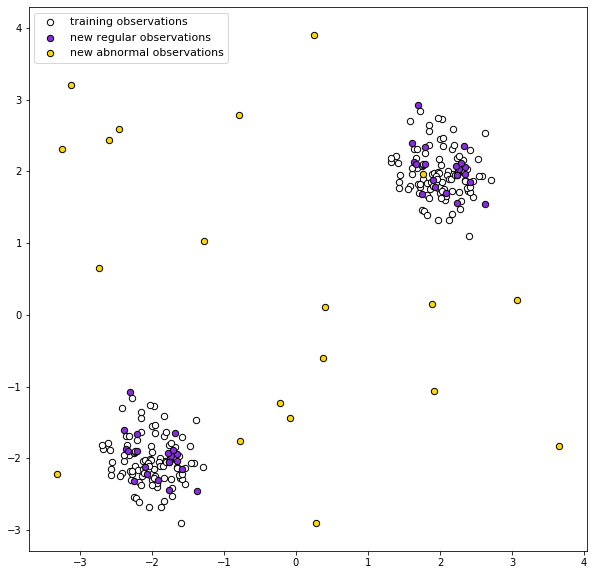

In [5]:
import matplotlib.font_manager

s = 40
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s, edgecolors='k')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s, edgecolors='k')
plt.legend(["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))

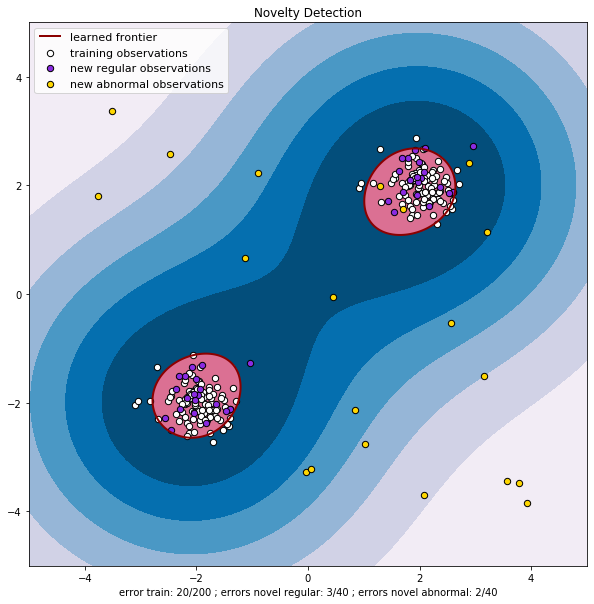

In [9]:
# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [14]:
print(clf.support_vectors_.shape)
clf.support_vectors_

(21, 2)


array([[ 2.31938616,  1.36042417],
       [ 2.52797139,  2.54167874],
       [ 2.29320155,  2.5944797 ],
       [ 2.6909292 ,  2.04503418],
       [ 2.41470117,  2.50120757],
       [ 1.38265413,  1.8848438 ],
       [ 2.02435228,  1.19972231],
       [ 1.43900164,  2.31946817],
       [ 2.17831421,  1.26401086],
       [ 2.60783024,  2.39847966],
       [ 1.87841125,  2.41173218],
       [-1.68061384, -2.63957583],
       [-1.47202861, -1.45832126],
       [-1.70679845, -1.4055203 ],
       [-2.61734587, -2.1151562 ],
       [-1.97564772, -2.80027769],
       [-1.76138688, -2.64644034],
       [-2.56099836, -1.68053183],
       [-1.82168579, -2.73598914],
       [-2.3426633 , -2.62901313],
       [-2.56565161, -2.13110561]])

In [15]:
clf.intercept_

array([-9.6150071])

### Ahora con los datos de fraude

In [8]:
X = Normal.values[:100000,:]
Nx = X.shape[0]
Xtrain = X[:int(Nx*0.7),:]
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(np.r_[X[int(Nx*0.7):,:],Fraud.values])
Y = np.r_[np.ones(X[int(Nx*0.7):,:].shape[0]),-1*np.ones(Fraud.values.shape[0])]
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.001)
clf.fit(Xtrain)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.001, kernel='rbf',
            max_iter=-1, nu=0.05, shrinking=True, tol=0.001, verbose=False)

In [9]:
Yest = clf.predict(Xtest)
Y = (Y + 1)/2
Yest = (Yest + 1)/2

Normalized confusion matrix
[[0.92479675 0.07520325]
 [0.0535     0.9465    ]]


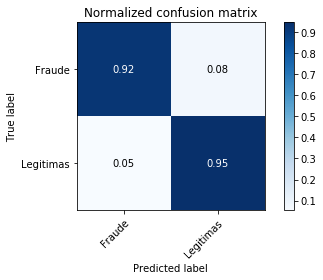

In [10]:
disp = plot_confusion_matrix(Y.astype(int),Yest.astype(int),class_names)

In [11]:
clf.intercept_

array([-2802.32041061])

In [12]:
clf.n_support_

array([3503], dtype=int32)

Normalized confusion matrix
[[0.69715447 0.30284553]
 [0.00926667 0.99073333]]


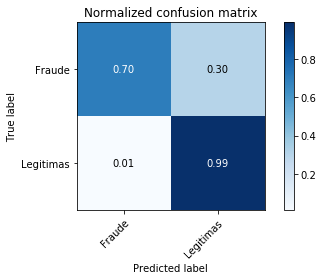

In [13]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.001)
clf.fit(Xtrain)
Yest = clf.predict(Xtest)
Yest = (Yest + 1)/2
disp = plot_confusion_matrix(Y.astype(int),Yest.astype(int),class_names)

## IsolationForest

Otra manera alternativa de detección de outliers basada en modelos de Machine Learning son los IsolationForest, ver: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

Consisten en la estimación de una puntuación (score) con base en el número de nodos promedio necesarios para aislar una muestra del resto del conjunto de datos, usando un Random Forest.

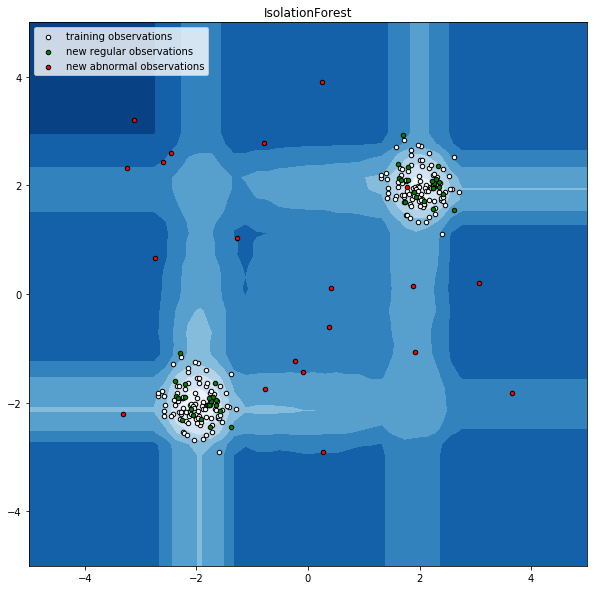

In [31]:
from sklearn.ensemble import IsolationForest
# fit the model
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

Text(0.5, 1.0, 'Predicciones para outliers')

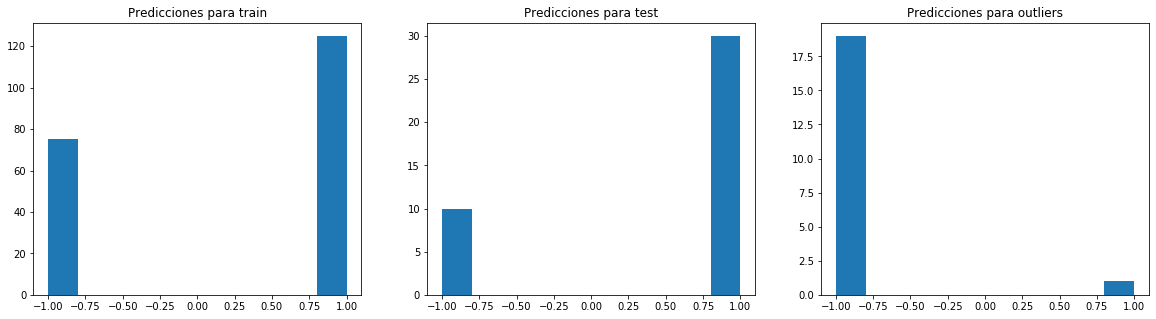

In [32]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(y_pred_train)
plt.title('Predicciones para train')
plt.subplot(132)
plt.hist(y_pred_test)
plt.title('Predicciones para test')
plt.subplot(133)
plt.hist(y_pred_outliers)
plt.title('Predicciones para outliers')

Text(0.5, 1.0, 'Scores para outliers')

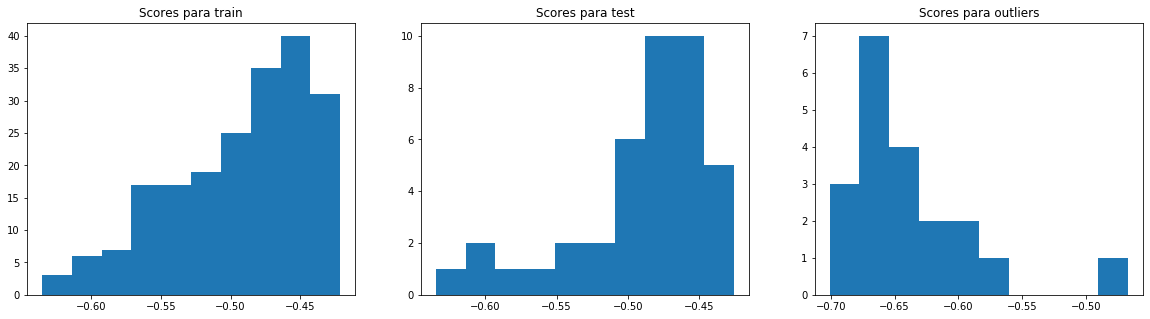

In [33]:
s_pred_train = clf.score_samples(X_train)
s_pred_test = clf.score_samples(X_test)
s_pred_outliers = clf.score_samples(X_outliers)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(s_pred_train)
plt.title('Scores para train')
plt.subplot(132)
plt.hist(s_pred_test)
plt.title('Scores para test')
plt.subplot(133)
plt.hist(s_pred_outliers)
plt.title('Scores para outliers')

Text(0.5, 1.0, 'Predicciones para outliers')

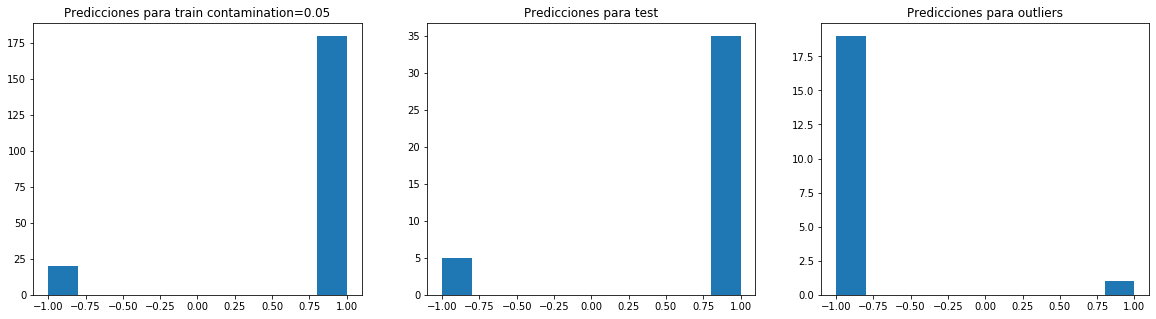

In [43]:
clf = IsolationForest(max_samples=100, random_state=rng, contamination=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(y_pred_train)
plt.title('Predicciones para train contamination=0.05')
plt.subplot(132)
plt.hist(y_pred_test)
plt.title('Predicciones para test')
plt.subplot(133)
plt.hist(y_pred_outliers)
plt.title('Predicciones para outliers')